<h3>Import necessary libraries</h3>

In [90]:
#Import library needed
import pandas as pd
import numpy as np
import nltk
from functools import reduce
from nltk.tokenize import word_tokenize, regexp_tokenize, sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import re
import string
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/adikusuma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adikusuma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h3>Read Data Source</h3>

In [91]:
#read data from source
data=pd.read_csv('datasets/IMDB Dataset.csv', sep=',')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<h2>Cleaning Data</h2>

In [92]:
#remove from html tag
def strip_html(text):
    soup = BeautifulSoup(text , 'html.parser')
    return soup.get_text()

#remove from square bracket
def remove_between_square_bracket(text):
    return re.sub('\[[^]]*\]', '', text)

#using 2 function to apply this function
def denoise_text(text):
    text = strip_html(text)
    text=remove_between_square_bracket(text)
    return text    

data['review']=data['review'].apply(denoise_text)

#remove special character
def remove_special_character(text, remove_digit=True):
    pattern = r'[^a-zA-z0-9\s]'
    text= re.sub(pattern, '', text)
    return text

data['review']=data['review'].apply(remove_special_character)

#lemmatization text
def lemmatization(text):
    lemmatization = WordNetLemmatizer()
    text = ' '.join([lemmatization.lemmatize(word) for word in text.split()])
    return text
    
data['review']=data['review'].apply(lemmatization)

#remove stop words
tokenizer=ToktokTokenizer()
def remove_stop_words(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in ENGLISH_STOP_WORDS]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in ENGLISH_STOP_WORDS]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

data['review']=data['review'].apply(remove_stop_words)

<h2>Visualize Positive Review</h2>

(-0.5, 399.5, 199.5, -0.5)

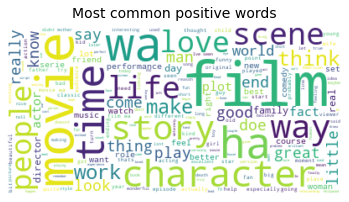

In [93]:
#select review with sentiment positive
positive_data = data[data['sentiment'] == 'positive']['review']
#merge selected rows become 1 rows
positive_data = reduce(lambda a, b : a+b, positive_data)
#create word_cloud for visualize most word
cloud_positive = WordCloud(background_color='white').generate(positive_data)


plt.imshow(cloud_positive, interpolation='bilinear') 
plt.title('Most common positive words', y = 1.02, size = 14) 
plt.axis("off")

<h2>Visualize Negative Review</h2>

(-0.5, 399.5, 199.5, -0.5)

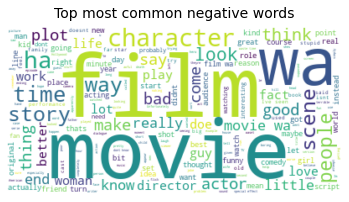

In [94]:
#select review with sentiment positive
negative_data = data[data['sentiment'] == 'negative']['review']
#merge selected rows become 1 rows
negative_data = reduce(lambda a, b : a+b, negative_data)
#create word_cloud for visualize most word
cloud_negative = WordCloud(background_color='white').generate(negative_data)


plt.imshow(cloud_negative, interpolation='bilinear') 
plt.title('Top most common negative words', y = 1.02, size = 14) 
plt.axis("off")


<h2>Check Balanced Data</h2>

In [95]:
print(data['sentiment'].value_counts())
print('Proportion of positive and negative sentiment:\n', data['sentiment'].value_counts()/len(data))

positive    25000
negative    25000
Name: sentiment, dtype: int64
Proportion of positive and negative sentiment:
 positive    0.5
negative    0.5
Name: sentiment, dtype: float64


<h2>Check Longest and Shortest Review For Estimated Maximum Features</h2>

In [96]:
length_reviews = data.review.str.len()
print("Longest Review", max(length_reviews))
print("Shortest Review", min(length_reviews))

Longest Review 8619
Shortest Review 17


<h2>Tokenize Review Column</h2>

In [97]:
word_tokens = [word_tokenize(review) for review in data['review']]
data['n_words'] = [len(word_tokens[i]) for i in range(len(word_tokens))]
data.head()

,review,sentiment,n_words
0,reviewer ha mentioned watching just 1 Oz episo...,positive,151
1,wonderful little production filming technique ...,positive,76
2,thought wa wonderful way spend time hot summer...,positive,80
3,Basically family little boy Jake think zombie ...,negative,62
4,Petter Matteis Love Time Money visually stunni...,positive,111


<h2>Using Tfidf For Weight Each Features</h2>

In [98]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500)
vectorizer.fit(data['review'])
X = vectorizer.transform(data['review'])
df_transform = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names_out())
df_transform.head()

,10,80,able,absolutely,act,acting,action,actor,actress,actually,...,writer,writing,written,wrong,year,yes,youll,young,youre,zombie
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.123284,0.000000,0.000000,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.115942,0.0,0.0,...,0.0,0.0,0.174862,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.128263,0.0,0.000000,0.154367,0.000000,0.000000
3,0.147057,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.152309,0.214341
4,0.000000,0.0,0.0,0.0,0.0,0.081294,0.106745,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


<h2>Transform Data for Define X and y</h2>

In [99]:
dropped = data.drop(['review', 'n_words'], axis=1)
transform = pd.concat([dropped, df_transform], axis=1)
transform.head()

,sentiment,10,80,able,absolutely,act,acting,action,actor,actress,...,writer,writing,written,wrong,year,yes,youll,young,youre,zombie
0,positive,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.123284,0.000000,0.000000,0.000000
1,positive,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.115942,0.0,...,0.0,0.0,0.174862,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,positive,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.128263,0.0,0.000000,0.154367,0.000000,0.000000
3,negative,0.147057,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.152309,0.214341
4,positive,0.000000,0.0,0.0,0.0,0.0,0.081294,0.106745,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


<h2>Define X, y, Split Train Test Data, and Calculate Accuracy Score </h2>

In [100]:
y = transform['sentiment']
X = transform.drop(['sentiment'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)
log_reg = LogisticRegression().fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)

print('Accuracy on the train set: ', log_reg.score(X_train, y_train))
print('Accuracy on the test set: ', log_reg.score(X_test, y_test))
print('Accuracy on the test set: ', accuracy_score(y_test, y_predicted))
print(confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy on the train set:  0.841275
Accuracy on the test set:  0.8295
Accuracy on the test set:  0.8295
[[0.4067 0.0897]
 [0.0808 0.4228]]


<h2>Calculate Confusion Matrix</h2>

/Users/adikusuma/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


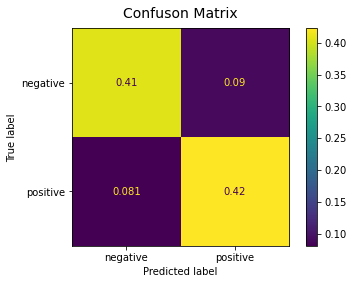

In [101]:
plot_confusion_matrix(log_reg, X_test, y_test, normalize='all')
plt.title('Confuson Matrix', y=1.02, size=14)
plt.show() 